# Import Dependencies

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as tfs
from torchinfo import summary

import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from tqdm import tqdm

from models.deeplabv3plus import DeepLabV3Plus
from evaluation_metrics import Metrics, timer
from visualizations import Plot

In [2]:
# Release GPU memory
torch.cuda.empty_cache()
print("GPU memory has been released.")

GPU memory has been released.


# CUDA Check

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using device: CPU")

Using device: NVIDIA GeForce RTX 3060 Laptop GPU


# Data Preprocessing and Augmentation

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Use ImageNet normalization parameters
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Define image dimensions
IMG_HEIGHT, IMG_WIDTH  = 256, 256

# Perform augmentations
trans = A.Compose([
    A.Resize(IMG_HEIGHT, IMG_WIDTH),  
    A.RandomResizedCrop(IMG_HEIGHT, IMG_WIDTH, scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),  
    A.RandomBrightnessContrast(p=0.2),  
    A.ShiftScaleRotate(p=0.2), 
    A.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ToTensorV2(transpose_mask=True) 
])

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.17 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


# Visualize augmentations

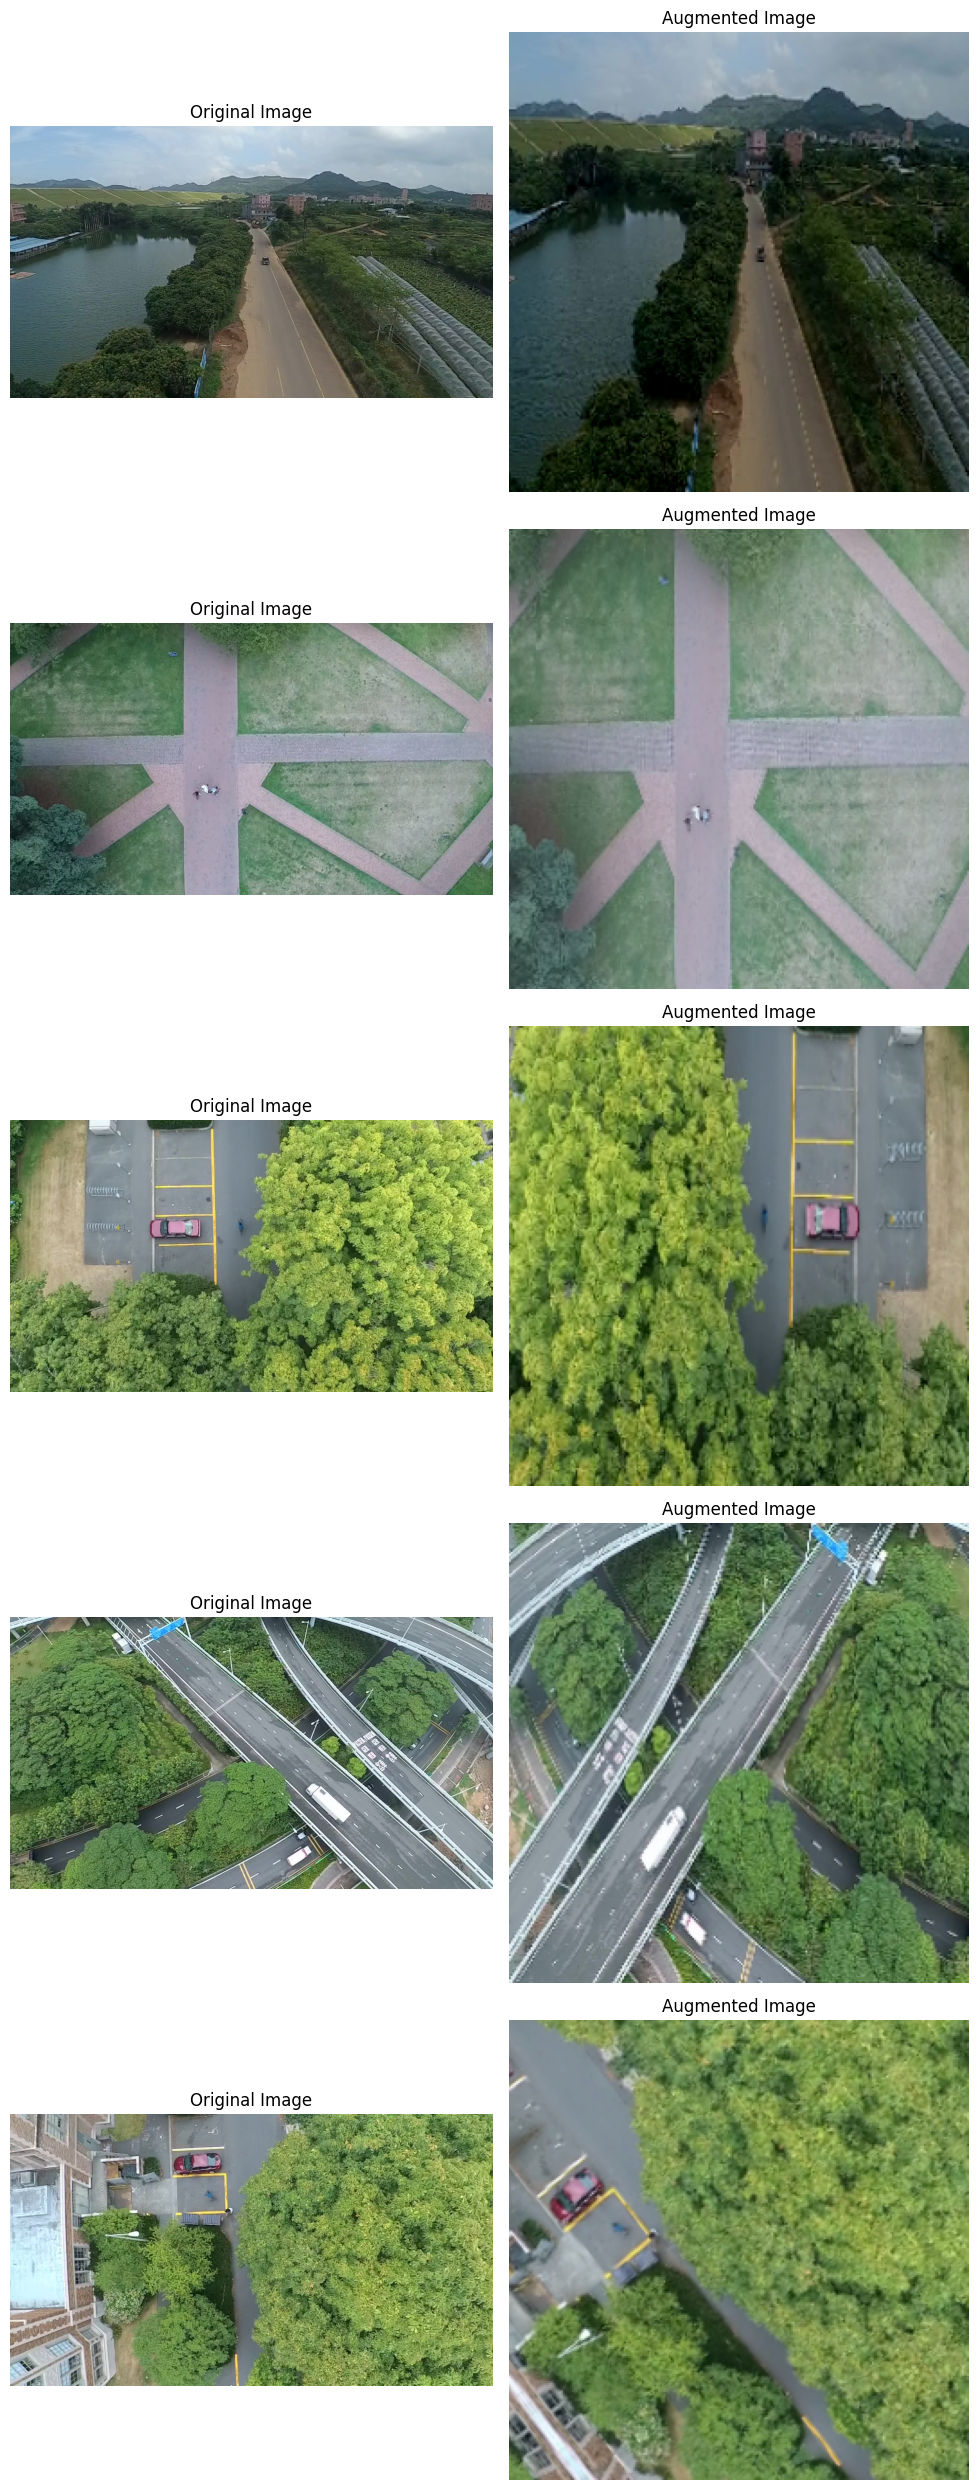

In [5]:
# Select 5 random images
folder_path = "./aeroscapes/JPEGImages"
jpg_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
selected_images = random.sample(jpg_files, 5)

# Plotting multiple images
num_images = len(selected_images)
fig, axes = plt.subplots(num_images, 2, figsize=(10, 5*num_images))

for i, img_path in enumerate(selected_images):
    img = Image.open(os.path.join(folder_path, img_path))
    
    # Convert PIL image to numpy array
    img_np = np.array(img)
    
    # Apply augmentation to the image
    augmented = trans(image=img_np)["image"]
    
    # Convert augmented image tensor to numpy array for visualization
    augmented_np = augmented.permute(1, 2, 0).cpu().numpy()
    augmented_np = (augmented_np * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1)
    
    # Convert numpy array to PIL Image for visualization
    augmented_pil = Image.fromarray((augmented_np * 255).astype(np.uint8))
    
    # Plotting original image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")
    
    # Plotting augmented image
    axes[i, 1].imshow(augmented_pil)
    axes[i, 1].set_title("Augmented Image")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

# Dataset

In [6]:
class AeroscapesDataset(Dataset):
    def __init__(self, root="./aeroscapes", data="trn", transformations=None):
        files = open(f"{root}/ImageSets/{data}.txt", "r").read().split("\n")
        self.img_paths, self.gt_paths = self.get_data_paths(root=root, files=files)
        self.transformations = transformations
        self.num_classes = 11
        assert len(self.img_paths) == len(self.gt_paths)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img, gt = self.get_img_gt(self.img_paths[idx], self.gt_paths[idx])

        if self.transformations: 
            transformed = self.transformations(image=img, mask=gt)
            img, gt = transformed["image"], transformed["mask"]

        return img, gt

    def get_img_gt(self, im_path, gt_path):
        return self.read_img(im_path), self.read_img(gt_path)

    def get_data_paths(self, root, files):
        return (
            [path for path in sorted(glob(f"{root}/JPEGImages/*.jpg")) if self.get_fname(path) in files],
            [path for path in sorted(glob(f"{root}/Visualizations/*.png")) if self.get_fname(path) in files]
        )

    def get_fname(self, path):
        return os.path.splitext(os.path.basename(path))[0]

    def read_img(self, path): 
        return cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)


# Dataloader

In [7]:
BATCH_SIZE = 16

def get_dataloaders(root, transformations, batch_size=BATCH_SIZE, split=[0.6, 0.2, 0.2], num_workers=8):
    assert sum(split) == 1., "Sum of the split must be exactly 1"

    # Create dataset
    dataset = AeroscapesDataset(root=root, data="trn", transformations=transformations)
    num_classes = dataset.num_classes
    total_len = len(dataset)

    # Calculate lengths for train, val, test splits
    train_len = int(total_len * split[0])
    val_len = int(total_len * split[1])
    test_len = total_len - train_len - val_len

    # Random split dataset into train, val, test
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

    print(f"\nThere are {len(train_dataset)} number of images in the train set")
    print(f"There are {len(val_dataset)} number of images in the validation set")
    print(f"There are {len(test_dataset)} number of images in the test set\n")

    # Create dataloaders
    train_loader = DataLoader(dataset=train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True, 
                              num_workers=num_workers)

    val_loader = DataLoader(dataset=val_dataset, 
                            batch_size=batch_size, 
                            shuffle=False, 
                            num_workers=num_workers)

    test_loader = DataLoader(dataset=test_dataset, 
                             batch_size=1, 
                             shuffle=False, 
                             num_workers=num_workers)

    return train_loader, val_loader, test_loader, num_classes


train_loader, val_loader, test_loader, num_classes = get_dataloaders(root="./aeroscapes/", transformations=trans, batch_size=BATCH_SIZE)



There are 1572 number of images in the train set
There are 524 number of images in the validation set
There are 525 number of images in the test set



# Visualize images and their segmentation masks

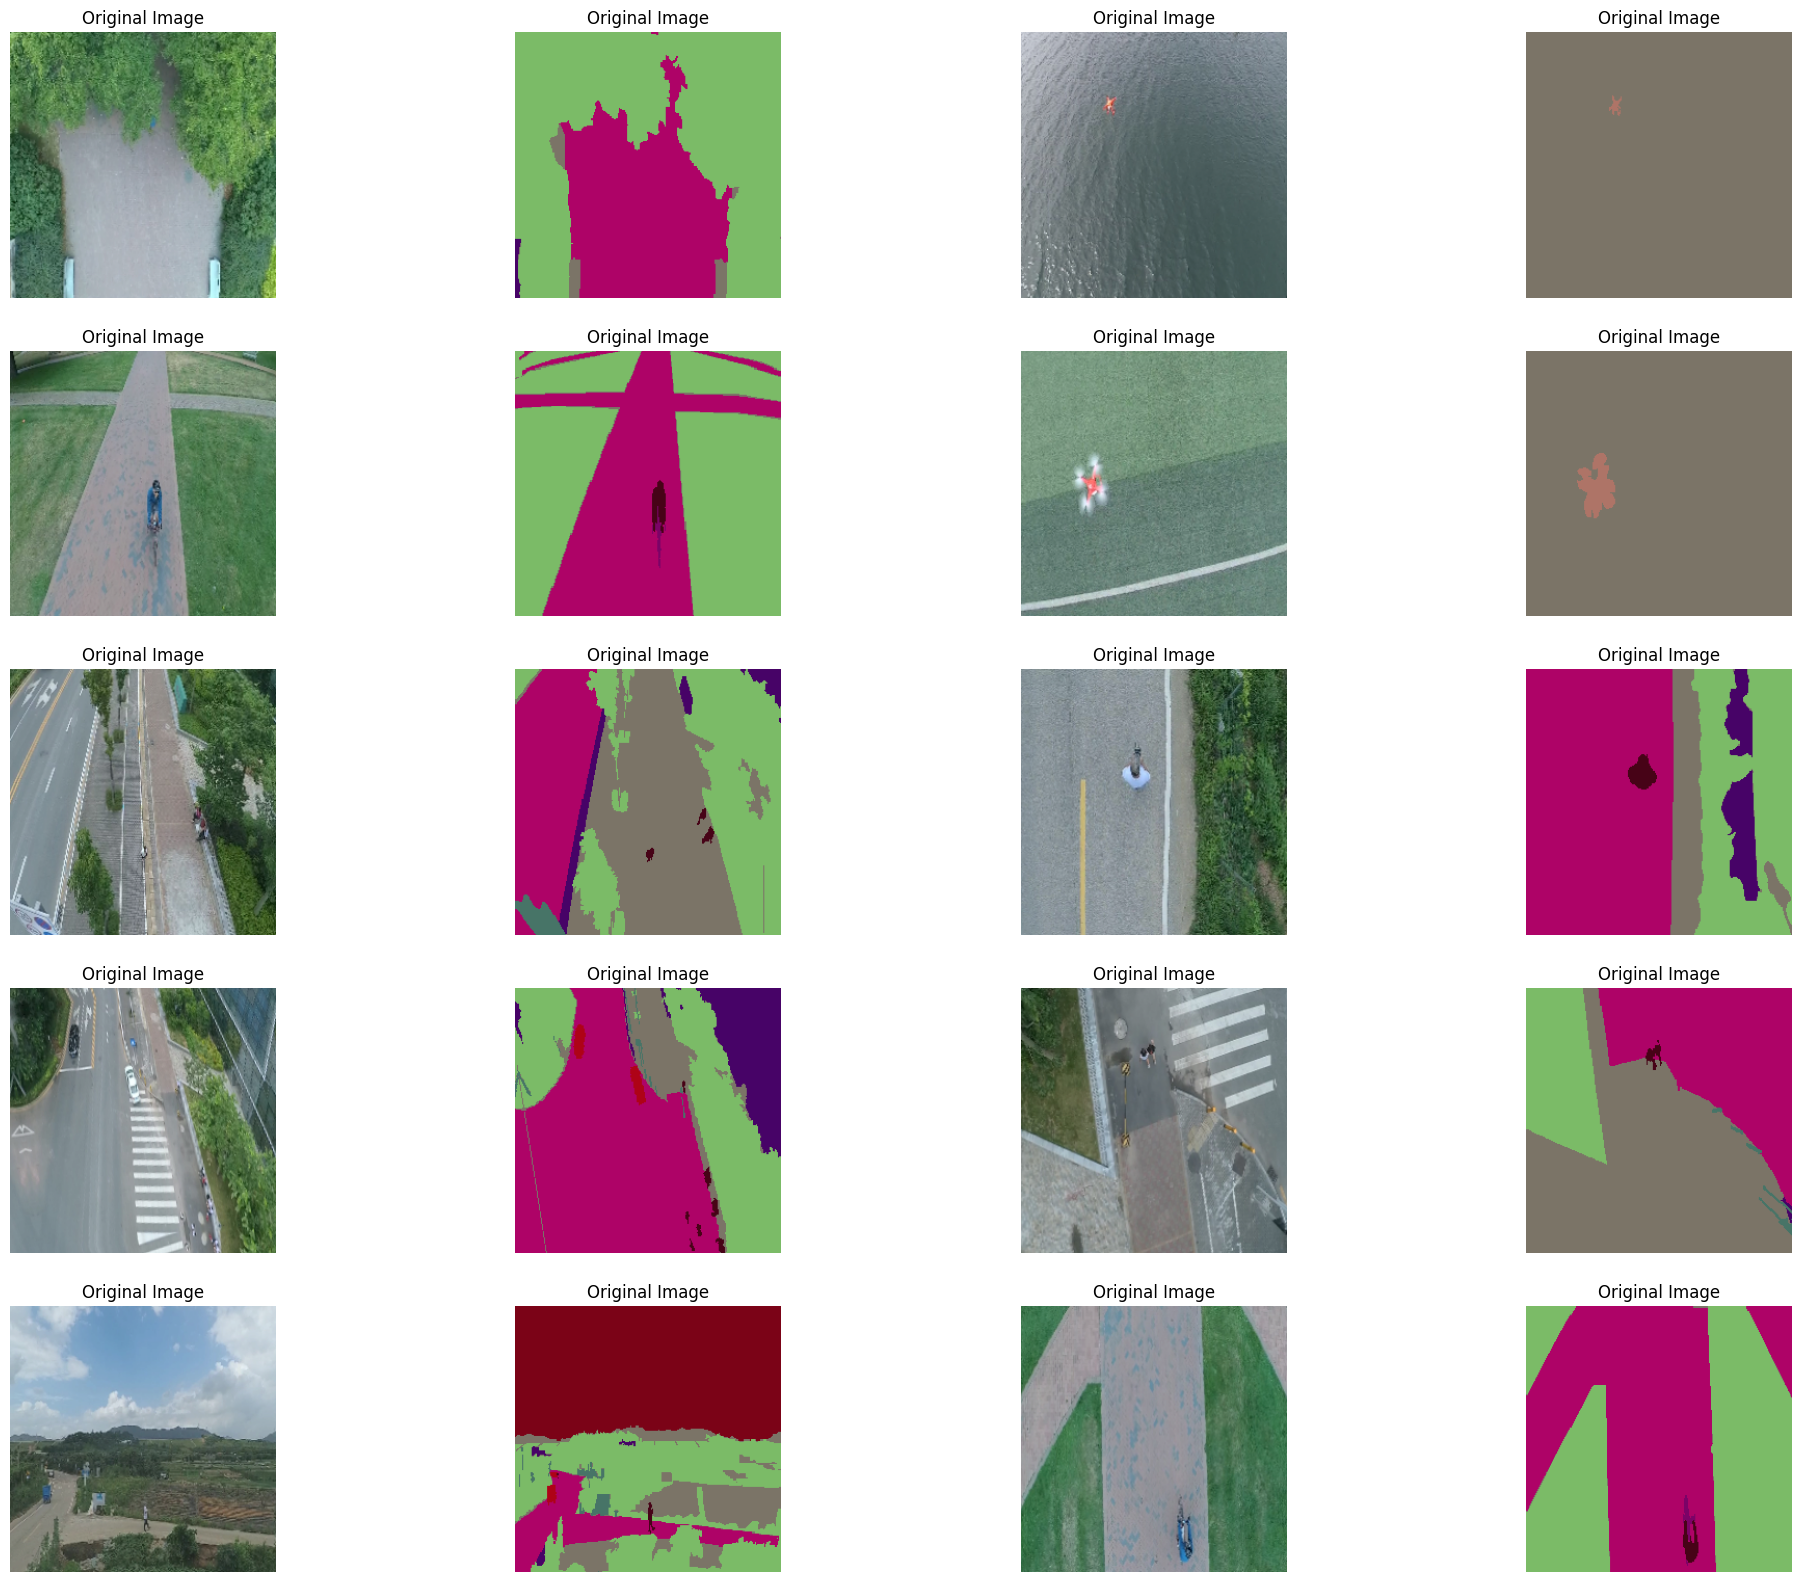

In [8]:
def tn_2_np(t):
    invTrans = tfs.Compose([ tfs.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                tfs.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]) ])

    rgb = True if len(t) == 3 else False

    return (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if rgb else (t*255).detach().cpu().numpy().astype(np.uint8)

def plot(rows, cols, count, im, gt = None, title = "Original Image"):

    plt.subplot(rows, cols, count)
    plt.imshow(tn_2_np(im.squeeze(0).float())) if gt else plt.imshow(tn_2_np(im.squeeze(0)))
    plt.axis("off"); plt.title(title)

    return count + 1

def visualize(ds, n_ims):

    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds)) for _ in range(n_ims)]

    for idx, index in enumerate(indices):

        if count == n_ims + 1: break
        im, gt = ds[index]

        # First Plot
        count = plot(rows, cols, count, im = im)

        # Second Plot
        count = plot(rows, cols, count, im = gt, gt = True)

visualize(train_loader.dataset, n_ims = 20)


# DeepLabv3+ Model

In [9]:
model = DeepLabV3Plus(backbone="mobilenetv2", attention=False, num_classes=num_classes).to(device)
summary(model, input_size=(BATCH_SIZE, 3, IMG_HEIGHT, IMG_WIDTH))

Layer (type:depth-idx)                                       Output Shape              Param #
DeepLabV3Plus                                                [16, 11, 256, 256]        --
├─Backbone: 1-1                                              [16, 24, 64, 64]          --
│    └─MobileNetV2: 2-1                                      --                        1,281,000
│    │    └─Sequential: 3-1                                  --                        2,223,872
├─ASPP: 1-2                                                  [16, 256, 8, 8]           --
│    └─Conv2d: 2-2                                           [16, 256, 8, 8]           327,680
│    └─AtrousConv: 2-3                                       [16, 256, 8, 8]           --
│    │    └─DepthwiseSeparableConv: 3-2                      [16, 256, 8, 8]           339,712
│    └─AtrousConv: 2-4                                       [16, 256, 8, 8]           --
│    │    └─DepthwiseSeparableConv: 3-3                      [16, 256, 

In [10]:
# import segmentation_models_pytorch as smp

# smp_model = smp.DeepLabV3Plus(encoder_name="xception", 
#                               decoder_atrous_rates=(6, 12, 18), 
#                               classes=num_classes).to(device)

# summary(smp_model, input_size=(BATCH_SIZE, 3, IMG_HEIGHT, IMG_WIDTH))

# Training and Validation Loop

In [11]:
EPOCHS = 50
CRITERION = torch.nn.CrossEntropyLoss()
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.0001)

In [12]:
# EPOCHS = 100

# CRITERION = torch.nn.CrossEntropyLoss()

# initial_lr = 0.001
# OPTIMIZER = torch.optim.SGD(model.parameters(), lr=initial_lr, momentum=0.95, weight_decay=1e-4, nesterov=True)

# # Poly learning rate policy (used in DeepLabV3+ paper)
# class PolyLR(torch.optim.lr_scheduler._LRScheduler):
#     def __init__(self, optimizer, max_iters, power=0.9, last_epoch=-1):
#         self.max_iters = max_iters
#         self.power = power
#         super(PolyLR, self).__init__(optimizer, last_epoch)

#     def get_lr(self):
#         return [base_lr * (1 - self.last_epoch / self.max_iters) ** self.power for base_lr in self.base_lrs]

# max_iters = EPOCHS * len(train_loader)
# SCHEDULER = PolyLR(OPTIMIZER, max_iters)

In [13]:
def train(model, 
          train_loader, 
          val_loader, 
          epochs,
          num_classes,
          loss_fn, 
          optimizer, 
        #   scheduler,
          device,
          save_prefix="deeplabv3plus",
          save_path="saved_models"):

    train_loss = []
    train_pixel_acc = [] 
    train_iou = []
    
    val_loss = []
    val_pixel_acc = []
    val_iou = []
    
    train_len = len(train_loader)
    val_len = len(val_loader)
    
    best_loss = np.inf
    not_improve = 0
    early_stop_threshold = 10
    
    os.makedirs(save_path, exist_ok=True)

    train_start = timer()
    print("Start training process...")

    for epoch in range(1, epochs + 1):
        tic = timer()
        train_loss_ = 0
        train_iou_ = 0 
        train_pixel_acc_ = 0

        print(f"Epoch {epoch} train process is started...")
        model.train()
        
        for idx, batch in enumerate(tqdm(train_loader)):

            imgs, gts = batch
            imgs, gts = imgs.to(device), gts.to(device)
            
            optimizer.zero_grad()  # Clear the gradients first
            
            preds = model(imgs)

            train_metrics = Metrics(preds, gts, loss_fn, num_classes=num_classes)
            loss = train_metrics.loss()
            train_iou_ += train_metrics.mIOU()
            train_pixel_acc_ += train_metrics.PixelAcc()
            train_loss_ += loss.item()

            loss.backward()  # Backpropagate current batch loss
            optimizer.step()
        
        # Update learning rate using PolyLR
        # scheduler.step()  

        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        
        val_loss_ = 0
        val_iou_ = 0
        val_pixel_acc_ = 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_loader)):

                imgs, gts = batch
                imgs, gts = imgs.to(device), gts.to(device)
                
                preds = model(imgs)

                val_metrics = Metrics(preds, gts, loss_fn, num_classes=num_classes)
                val_loss_ += val_metrics.loss().item()
                val_iou_ += val_metrics.mIOU()
                val_pixel_acc_ += val_metrics.PixelAcc()

        print(f"Epoch {epoch} train process is completed.")

        train_loss_ /= train_len
        train_iou_ /= train_len
        train_pixel_acc_ /= train_len

        val_loss_ /= val_len
        val_iou_ /=  val_len
        val_pixel_acc_ /=   val_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {timer(tic):.3f} secs")
        print(f"Train Loss         -> {train_loss_:.3f}")
        print(f"Train PA           -> {train_pixel_acc_:.3f}")
        print(f"Train IoU          -> {train_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pixel_acc_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}")
        # print(f"Current LR         -> {scheduler.get_last_lr()[0]:.6f}\n")

        train_loss.append(train_loss_)
        train_iou.append(train_iou_)
        train_pixel_acc.append(train_pixel_acc_)

        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pixel_acc.append(val_pixel_acc_)

        if val_loss_ < best_loss:
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            not_improve = 0  # Reset counter
            print("Saving the model with the best loss value...")
            torch.save(model.state_dict(), f"{save_path}/{save_prefix}_best_model.pt")
        else:
            not_improve += 1
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve >= early_stop_threshold:
                print(f"Stopping training process because loss did not decrease for {early_stop_threshold} epochs!")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

    print(f"Train process is completed in {(timer(train_start)) / 60:.3f} minutes.")

    return {"tr_loss": train_loss, "tr_iou": train_iou, "tr_pa": train_pixel_acc,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pixel_acc}


# Training setup
history = train(
    model,
    train_loader,
    val_loader,
    EPOCHS,
    num_classes,
    CRITERION,
    OPTIMIZER,
    # SCHEDULER,
    device,
    save_prefix="deeplabv3plus_aeroscapes",
)

Start training process...
Epoch 1 train process is started...


100%|██████████| 99/99 [00:12<00:00,  7.98it/s]


Epoch 1 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 13.27it/s]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 14.906 secs
Train Loss         -> 1.128
Train PA           -> 0.757
Train IoU          -> 0.623
Validation Loss    -> 0.493
Validation PA      -> 0.915
Validation IoU     -> 0.769
Loss decreased from inf to 0.493!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.64it/s]


Epoch 2 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.13it/s]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 12.462 secs
Train Loss         -> 0.354
Train PA           -> 0.926
Train IoU          -> 0.775
Validation Loss    -> 0.246
Validation PA      -> 0.946
Validation IoU     -> 0.829
Loss decreased from 0.493 to 0.246!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.23it/s]


Epoch 3 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 12.74it/s]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 13.324 secs
Train Loss         -> 0.220
Train PA           -> 0.947
Train IoU          -> 0.804
Validation Loss    -> 0.171
Validation PA      -> 0.955
Validation IoU     -> 0.845
Loss decreased from 0.246 to 0.171!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.60it/s]


Epoch 4 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.62it/s]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 12.434 secs
Train Loss         -> 0.167
Train PA           -> 0.955
Train IoU          -> 0.842
Validation Loss    -> 0.138
Validation PA      -> 0.960
Validation IoU     -> 0.844
Loss decreased from 0.171 to 0.138!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.60it/s]


Epoch 5 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.56it/s]


Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 12.583 secs
Train Loss         -> 0.138
Train PA           -> 0.959
Train IoU          -> 0.828
Validation Loss    -> 0.121
Validation PA      -> 0.963
Validation IoU     -> 0.859
Loss decreased from 0.138 to 0.121!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.59it/s]


Epoch 6 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.60it/s]


Epoch 6 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process results: 

Train Time         -> 12.595 secs
Train Loss         -> 0.122
Train PA           -> 0.962
Train IoU          -> 0.834
Validation Loss    -> 0.106
Validation PA      -> 0.965
Validation IoU     -> 0.863
Loss decreased from 0.121 to 0.106!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.60it/s]


Epoch 7 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.46it/s]


Epoch 7 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process results: 

Train Time         -> 12.607 secs
Train Loss         -> 0.112
Train PA           -> 0.964
Train IoU          -> 0.842
Validation Loss    -> 0.105
Validation PA      -> 0.965
Validation IoU     -> 0.854
Loss decreased from 0.106 to 0.105!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process is started...


100%|██████████| 99/99 [00:15<00:00,  6.26it/s]


Epoch 8 validation process is started...


100%|██████████| 33/33 [00:03<00:00, 10.80it/s]


Epoch 8 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process results: 

Train Time         -> 18.867 secs
Train Loss         -> 0.103
Train PA           -> 0.966
Train IoU          -> 0.846
Validation Loss    -> 0.098
Validation PA      -> 0.967
Validation IoU     -> 0.856
Loss decreased from 0.105 to 0.098!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.07it/s]


Epoch 9 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.41it/s]


Epoch 9 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process results: 

Train Time         -> 13.209 secs
Train Loss         -> 0.097
Train PA           -> 0.967
Train IoU          -> 0.845
Validation Loss    -> 0.103
Validation PA      -> 0.967
Validation IoU     -> 0.857
Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.22it/s]


Epoch 10 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 12.91it/s]


Epoch 10 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process results: 

Train Time         -> 13.296 secs
Train Loss         -> 0.093
Train PA           -> 0.968
Train IoU          -> 0.851
Validation Loss    -> 0.090
Validation PA      -> 0.968
Validation IoU     -> 0.869
Loss decreased from 0.098 to 0.090!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.43it/s]


Epoch 11 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.23it/s]


Epoch 11 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process results: 

Train Time         -> 12.677 secs
Train Loss         -> 0.087
Train PA           -> 0.969
Train IoU          -> 0.858
Validation Loss    -> 0.085
Validation PA      -> 0.969
Validation IoU     -> 0.860
Loss decreased from 0.090 to 0.085!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.40it/s]


Epoch 12 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.89it/s]


Epoch 12 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process results: 

Train Time         -> 12.751 secs
Train Loss         -> 0.084
Train PA           -> 0.970
Train IoU          -> 0.865
Validation Loss    -> 0.084
Validation PA      -> 0.969
Validation IoU     -> 0.860
Loss decreased from 0.085 to 0.084!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.39it/s]


Epoch 13 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.22it/s]


Epoch 13 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process results: 

Train Time         -> 12.721 secs
Train Loss         -> 0.084
Train PA           -> 0.970
Train IoU          -> 0.865
Validation Loss    -> 0.081
Validation PA      -> 0.970
Validation IoU     -> 0.872
Loss decreased from 0.084 to 0.081!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.42it/s]


Epoch 14 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.17it/s]


Epoch 14 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 train process results: 

Train Time         -> 12.694 secs
Train Loss         -> 0.079
Train PA           -> 0.971
Train IoU          -> 0.849
Validation Loss    -> 0.076
Validation PA      -> 0.971
Validation IoU     -> 0.874
Loss decreased from 0.081 to 0.076!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.38it/s]


Epoch 15 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.90it/s]


Epoch 15 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 train process results: 

Train Time         -> 12.774 secs
Train Loss         -> 0.078
Train PA           -> 0.971
Train IoU          -> 0.852
Validation Loss    -> 0.077
Validation PA      -> 0.971
Validation IoU     -> 0.873
Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 16 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.47it/s]


Epoch 16 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 13.47it/s]


Epoch 16 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 16 train process results: 

Train Time         -> 12.913 secs
Train Loss         -> 0.074
Train PA           -> 0.972
Train IoU          -> 0.860
Validation Loss    -> 0.075
Validation PA      -> 0.972
Validation IoU     -> 0.866
Loss decreased from 0.076 to 0.075!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 17 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.22it/s]


Epoch 17 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.83it/s]


Epoch 17 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 17 train process results: 

Train Time         -> 12.971 secs
Train Loss         -> 0.072
Train PA           -> 0.973
Train IoU          -> 0.857
Validation Loss    -> 0.074
Validation PA      -> 0.972
Validation IoU     -> 0.866
Loss decreased from 0.075 to 0.074!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 18 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.47it/s]


Epoch 18 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.02it/s]


Epoch 18 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 18 train process results: 

Train Time         -> 12.663 secs
Train Loss         -> 0.070
Train PA           -> 0.973
Train IoU          -> 0.862
Validation Loss    -> 0.072
Validation PA      -> 0.973
Validation IoU     -> 0.878
Loss decreased from 0.074 to 0.072!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 19 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.26it/s]


Epoch 19 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.85it/s]


Epoch 19 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 19 train process results: 

Train Time         -> 12.917 secs
Train Loss         -> 0.068
Train PA           -> 0.974
Train IoU          -> 0.874
Validation Loss    -> 0.072
Validation PA      -> 0.973
Validation IoU     -> 0.870
Loss decreased from 0.072 to 0.072!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 20 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.41it/s]


Epoch 20 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.98it/s]


Epoch 20 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 20 train process results: 

Train Time         -> 12.725 secs
Train Loss         -> 0.066
Train PA           -> 0.975
Train IoU          -> 0.874
Validation Loss    -> 0.070
Validation PA      -> 0.973
Validation IoU     -> 0.878
Loss decreased from 0.072 to 0.070!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 21 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.29it/s]


Epoch 21 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.49it/s]


Epoch 21 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 21 train process results: 

Train Time         -> 12.937 secs
Train Loss         -> 0.065
Train PA           -> 0.975
Train IoU          -> 0.879
Validation Loss    -> 0.067
Validation PA      -> 0.974
Validation IoU     -> 0.886
Loss decreased from 0.070 to 0.067!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 22 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.23it/s]


Epoch 22 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.48it/s]


Epoch 22 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 22 train process results: 

Train Time         -> 13.007 secs
Train Loss         -> 0.066
Train PA           -> 0.975
Train IoU          -> 0.865
Validation Loss    -> 0.072
Validation PA      -> 0.973
Validation IoU     -> 0.888
Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 23 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.29it/s]


Epoch 23 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.21it/s]


Epoch 23 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 23 train process results: 

Train Time         -> 12.982 secs
Train Loss         -> 0.065
Train PA           -> 0.975
Train IoU          -> 0.876
Validation Loss    -> 0.067
Validation PA      -> 0.974
Validation IoU     -> 0.874
Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 24 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.33it/s]


Epoch 24 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.12it/s]


Epoch 24 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 24 train process results: 

Train Time         -> 12.795 secs
Train Loss         -> 0.065
Train PA           -> 0.975
Train IoU          -> 0.871
Validation Loss    -> 0.071
Validation PA      -> 0.973
Validation IoU     -> 0.877
Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 25 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.40it/s]


Epoch 25 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.22it/s]


Epoch 25 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 25 train process results: 

Train Time         -> 12.711 secs
Train Loss         -> 0.065
Train PA           -> 0.975
Train IoU          -> 0.883
Validation Loss    -> 0.067
Validation PA      -> 0.974
Validation IoU     -> 0.880
Loss decreased from 0.067 to 0.067!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 26 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.33it/s]


Epoch 26 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.19it/s]


Epoch 26 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 26 train process results: 

Train Time         -> 12.792 secs
Train Loss         -> 0.062
Train PA           -> 0.976
Train IoU          -> 0.883
Validation Loss    -> 0.065
Validation PA      -> 0.975
Validation IoU     -> 0.878
Loss decreased from 0.067 to 0.065!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 27 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.41it/s]


Epoch 27 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.16it/s]


Epoch 27 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 27 train process results: 

Train Time         -> 12.704 secs
Train Loss         -> 0.061
Train PA           -> 0.976
Train IoU          -> 0.888
Validation Loss    -> 0.064
Validation PA      -> 0.975
Validation IoU     -> 0.881
Loss decreased from 0.065 to 0.064!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 28 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.33it/s]


Epoch 28 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.05it/s]


Epoch 28 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 28 train process results: 

Train Time         -> 12.813 secs
Train Loss         -> 0.059
Train PA           -> 0.977
Train IoU          -> 0.894
Validation Loss    -> 0.063
Validation PA      -> 0.975
Validation IoU     -> 0.886
Loss decreased from 0.064 to 0.063!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 29 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.36it/s]


Epoch 29 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.02it/s]


Epoch 29 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 29 train process results: 

Train Time         -> 12.780 secs
Train Loss         -> 0.059
Train PA           -> 0.977
Train IoU          -> 0.897
Validation Loss    -> 0.061
Validation PA      -> 0.976
Validation IoU     -> 0.885
Loss decreased from 0.063 to 0.061!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 30 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.29it/s]


Epoch 30 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 15.09it/s]


Epoch 30 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 30 train process results: 

Train Time         -> 12.849 secs
Train Loss         -> 0.058
Train PA           -> 0.977
Train IoU          -> 0.893
Validation Loss    -> 0.063
Validation PA      -> 0.975
Validation IoU     -> 0.884
Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 31 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.26it/s]


Epoch 31 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.76it/s]


Epoch 31 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 31 train process results: 

Train Time         -> 12.928 secs
Train Loss         -> 0.058
Train PA           -> 0.977
Train IoU          -> 0.891
Validation Loss    -> 0.060
Validation PA      -> 0.976
Validation IoU     -> 0.886
Loss decreased from 0.061 to 0.060!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 32 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.34it/s]


Epoch 32 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.33it/s]


Epoch 32 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 32 train process results: 

Train Time         -> 12.907 secs
Train Loss         -> 0.059
Train PA           -> 0.977
Train IoU          -> 0.899
Validation Loss    -> 0.063
Validation PA      -> 0.976
Validation IoU     -> 0.879
Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 33 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.35it/s]


Epoch 33 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.73it/s]


Epoch 33 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 33 train process results: 

Train Time         -> 12.832 secs
Train Loss         -> 0.061
Train PA           -> 0.976
Train IoU          -> 0.898
Validation Loss    -> 0.062
Validation PA      -> 0.976
Validation IoU     -> 0.885
Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 34 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.35it/s]


Epoch 34 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.99it/s]


Epoch 34 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 34 train process results: 

Train Time         -> 12.796 secs
Train Loss         -> 0.057
Train PA           -> 0.978
Train IoU          -> 0.910
Validation Loss    -> 0.059
Validation PA      -> 0.977
Validation IoU     -> 0.885
Loss decreased from 0.060 to 0.059!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 35 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.24it/s]


Epoch 35 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.65it/s]


Epoch 35 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 35 train process results: 

Train Time         -> 12.974 secs
Train Loss         -> 0.056
Train PA           -> 0.978
Train IoU          -> 0.898
Validation Loss    -> 0.060
Validation PA      -> 0.977
Validation IoU     -> 0.887
Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 36 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.31it/s]


Epoch 36 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.42it/s]


Epoch 36 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 36 train process results: 

Train Time         -> 12.924 secs
Train Loss         -> 0.058
Train PA           -> 0.977
Train IoU          -> 0.898
Validation Loss    -> 0.059
Validation PA      -> 0.977
Validation IoU     -> 0.897
Loss decreased from 0.059 to 0.059!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 37 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.33it/s]


Epoch 37 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.34it/s]


Epoch 37 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 37 train process results: 

Train Time         -> 12.919 secs
Train Loss         -> 0.055
Train PA           -> 0.978
Train IoU          -> 0.906
Validation Loss    -> 0.058
Validation PA      -> 0.977
Validation IoU     -> 0.889
Loss decreased from 0.059 to 0.058!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 38 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.40it/s]


Epoch 38 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.53it/s]


Epoch 38 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 38 train process results: 

Train Time         -> 12.813 secs
Train Loss         -> 0.053
Train PA           -> 0.979
Train IoU          -> 0.910
Validation Loss    -> 0.057
Validation PA      -> 0.978
Validation IoU     -> 0.898
Loss decreased from 0.058 to 0.057!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 39 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.30it/s]


Epoch 39 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.81it/s]


Epoch 39 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 39 train process results: 

Train Time         -> 12.881 secs
Train Loss         -> 0.054
Train PA           -> 0.979
Train IoU          -> 0.910
Validation Loss    -> 0.058
Validation PA      -> 0.977
Validation IoU     -> 0.890
Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 40 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.20it/s]


Epoch 40 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 13.70it/s]


Epoch 40 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 40 train process results: 

Train Time         -> 13.174 secs
Train Loss         -> 0.053
Train PA           -> 0.979
Train IoU          -> 0.913
Validation Loss    -> 0.055
Validation PA      -> 0.978
Validation IoU     -> 0.900
Loss decreased from 0.057 to 0.055!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 41 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.34it/s]


Epoch 41 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.11it/s]


Epoch 41 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 41 train process results: 

Train Time         -> 12.946 secs
Train Loss         -> 0.052
Train PA           -> 0.979
Train IoU          -> 0.908
Validation Loss    -> 0.058
Validation PA      -> 0.977
Validation IoU     -> 0.892
Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 42 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.33it/s]


Epoch 42 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.61it/s]


Epoch 42 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 42 train process results: 

Train Time         -> 12.878 secs
Train Loss         -> 0.050
Train PA           -> 0.980
Train IoU          -> 0.910
Validation Loss    -> 0.056
Validation PA      -> 0.978
Validation IoU     -> 0.899
Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 43 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.26it/s]


Epoch 43 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.59it/s]


Epoch 43 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 43 train process results: 

Train Time         -> 12.961 secs
Train Loss         -> 0.051
Train PA           -> 0.979
Train IoU          -> 0.911
Validation Loss    -> 0.059
Validation PA      -> 0.977
Validation IoU     -> 0.890
Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 44 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.28it/s]


Epoch 44 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.55it/s]


Epoch 44 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 44 train process results: 

Train Time         -> 12.941 secs
Train Loss         -> 0.050
Train PA           -> 0.980
Train IoU          -> 0.915
Validation Loss    -> 0.054
Validation PA      -> 0.979
Validation IoU     -> 0.898
Loss decreased from 0.055 to 0.054!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 45 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.27it/s]


Epoch 45 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.41it/s]


Epoch 45 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 45 train process results: 

Train Time         -> 12.977 secs
Train Loss         -> 0.050
Train PA           -> 0.980
Train IoU          -> 0.906
Validation Loss    -> 0.056
Validation PA      -> 0.979
Validation IoU     -> 0.898
Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 46 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.36it/s]


Epoch 46 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.44it/s]


Epoch 46 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 46 train process results: 

Train Time         -> 12.872 secs
Train Loss         -> 0.049
Train PA           -> 0.980
Train IoU          -> 0.911
Validation Loss    -> 0.056
Validation PA      -> 0.978
Validation IoU     -> 0.893
Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 47 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.19it/s]


Epoch 47 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.60it/s]


Epoch 47 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 47 train process results: 

Train Time         -> 13.045 secs
Train Loss         -> 0.049
Train PA           -> 0.980
Train IoU          -> 0.917
Validation Loss    -> 0.055
Validation PA      -> 0.979
Validation IoU     -> 0.895
Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 48 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.29it/s]


Epoch 48 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.61it/s]


Epoch 48 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 48 train process results: 

Train Time         -> 12.926 secs
Train Loss         -> 0.052
Train PA           -> 0.979
Train IoU          -> 0.920
Validation Loss    -> 0.056
Validation PA      -> 0.978
Validation IoU     -> 0.907
Loss did not decrease for 4 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 49 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.28it/s]


Epoch 49 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 13.99it/s]


Epoch 49 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 49 train process results: 

Train Time         -> 13.037 secs
Train Loss         -> 0.052
Train PA           -> 0.979
Train IoU          -> 0.914
Validation Loss    -> 0.056
Validation PA      -> 0.978
Validation IoU     -> 0.916
Loss did not decrease for 5 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 50 train process is started...


100%|██████████| 99/99 [00:10<00:00,  9.36it/s]


Epoch 50 validation process is started...


100%|██████████| 33/33 [00:02<00:00, 14.48it/s]

Epoch 50 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 50 train process results: 

Train Time         -> 12.865 secs
Train Loss         -> 0.052
Train PA           -> 0.979
Train IoU          -> 0.911
Validation Loss    -> 0.057
Validation PA      -> 0.978
Validation IoU     -> 0.906
Loss did not decrease for 6 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Train process is completed in 10.883 minutes.


# Visualize training results

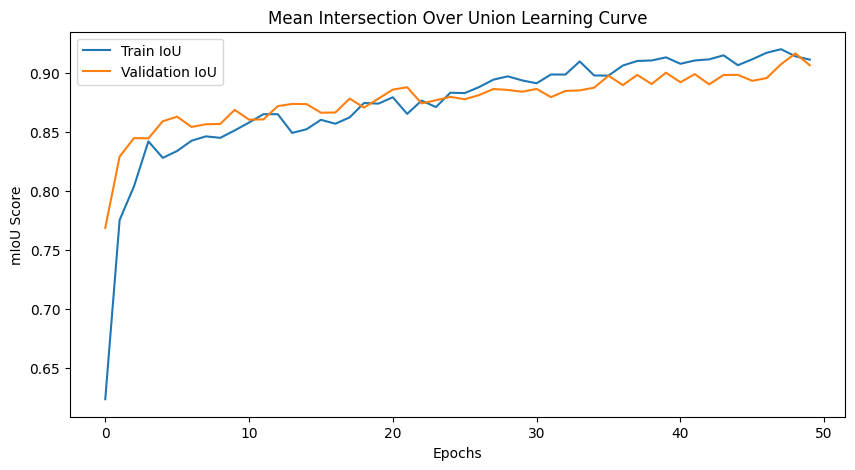

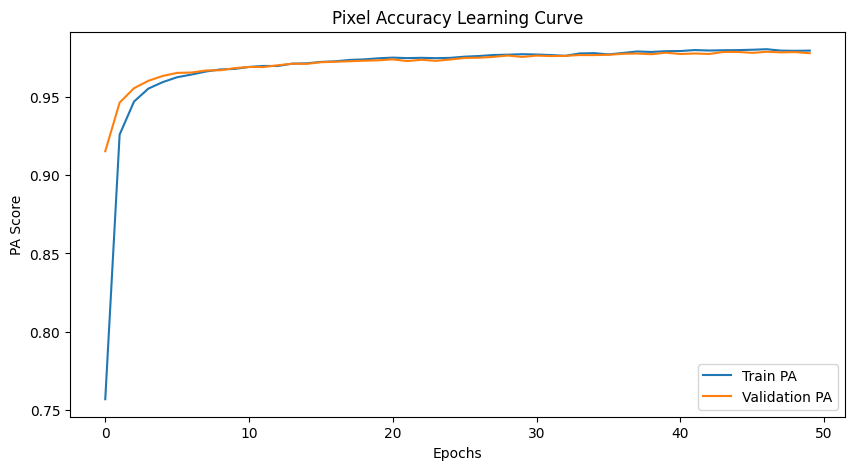

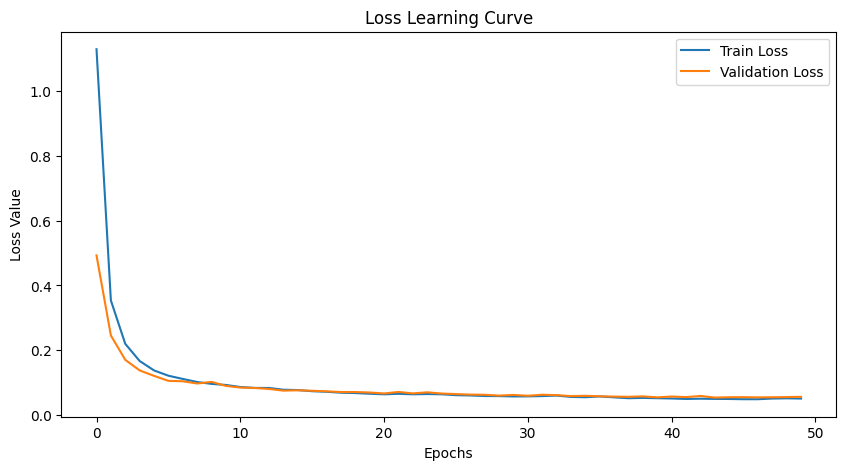

In [14]:
Plot(history)

# Build the testing loop

In [17]:
class Test():
    def __init__(self, model, test_loader, loss_fn, device):
        self.model = model
        self.test_loader = test_loader
        self.loss_fn = loss_fn
        self.device = device
    
    def run(self):
        self.model.eval()
        test_loss = 0
        test_iou = 0
        test_pixel_acc = 0
        test_len = len(self.test_loader)

        imgs = []
        gts = []
        preds = []

        with torch.no_grad():
            for batch in tqdm(self.test_loader):
                imgs_batch, gts_batch = batch
                imgs_batch, gts_batch = imgs_batch.to(self.device), gts_batch.to(self.device)

                # Forward pass
                preds_batch = self.model(imgs_batch)
                
                # Calculate metrics
                metrics = Metrics(preds_batch, gts_batch, self.loss_fn)
                test_loss += metrics.loss().item()
                test_iou += metrics.mIOU()
                test_pixel_acc += metrics.PixelAcc()

                # Collect data for visualization
                preds_batch = torch.argmax(preds_batch, dim=1)
                imgs.extend(imgs_batch.cpu())
                gts.extend(gts_batch.cpu())
                preds.extend(preds_batch.cpu())

        # Calculate average metrics
        test_loss /= test_len
        test_iou /= test_len
        test_pixel_acc /= test_len

        return imgs, gts, preds, test_loss, test_iou, test_pixel_acc


test = Test(model, test_loader, CRITERION, device)
imgs, gts, preds, test_loss, test_iou, test_pixel_acc = test.run()

print(f"Test Loss: {test_loss:.4f}")
print(f"Test mIoU: {test_iou:.4f}")
print(f"Test PA: {test_pixel_acc:.4f}")

100%|██████████| 525/525 [00:09<00:00, 56.49it/s]

Test Loss: 0.0545
Test mIoU: 0.9313
Test PA: 0.9786


# Visualize testing results

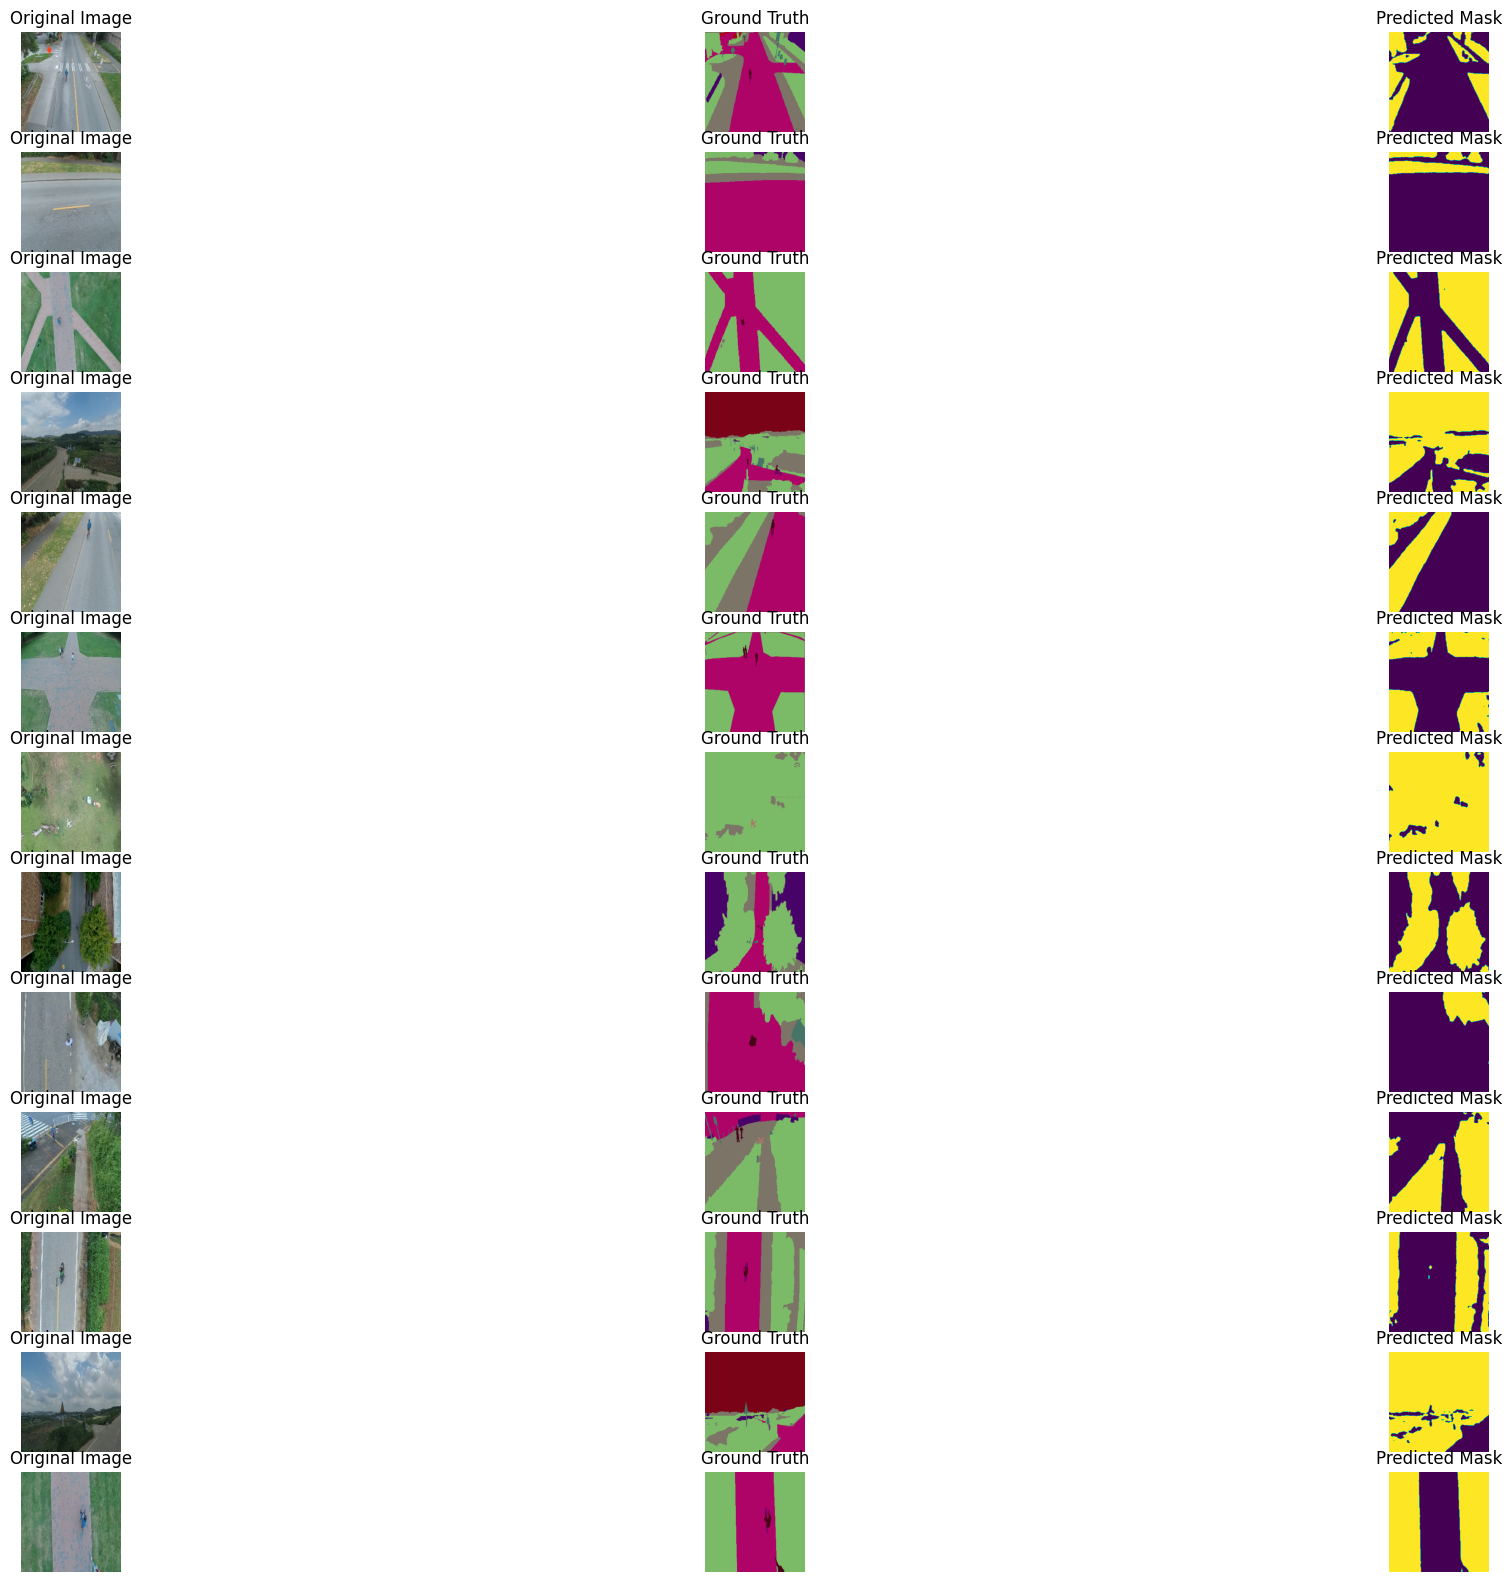

In [32]:
def inference(dataloader, model, device, num_imgs=40):

    cols = num_imgs // 3
    rows = num_imgs // cols

    count = 1
    imgs = []
    gts = []
    preds = []
    indices = [random.randint(0, len(dataloader.dataset) - 1) for _ in range(num_imgs)]

    for idx, data in enumerate(dataloader):

        if idx not in indices: 
            continue
        else:
            im, gt = data
            
            # Get predicted mask
            with torch.no_grad(): 
                pred = torch.argmax(model(im.to(device)), dim = 1)
            
            imgs.append(im)
            gts.append(gt)
            preds.append(pred)

    plt.figure(figsize = (25, 20))
    for idx, (img, gt, pred) in enumerate(zip(imgs, gts, preds)):
        if idx == cols: 
            break

        # First plot
        count = plot(cols, rows, count, im=img, title="Original Image")

        # Second plot
        count = plot(cols, rows, count, im=gt, gt=True, title="Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im=pred, title="Predicted Mask")


deeplab = DeepLabV3Plus(backbone="mobilenetv2", attention=False, num_classes=num_classes)
deeplab.load_state_dict(torch.load("saved_models/deeplabv3plus_aeroscapes_best_model.pt"))
deeplab.to(device)
deeplab.eval()

inference(dataloader=test_loader, model=deeplab, device=device)